In [1]:
%pylab inline
import pandas as pd
import json
import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
hitid = '30EV7DWJTUUBPZRXGGL2A0PGANYY6K'
date = "2019-07-10"

In [3]:
data = pd.read_csv("Empirica Data - 2019-07-10 19-17-54/players.csv", parse_dates=['readyAt', 'createdAt', 'exitAt'])
data.fillna(0, inplace=True)
data['urlParams'] = data['urlParams'].apply(lambda x: json.loads(x))
data['TurkID'] = data['urlParams'].apply(lambda x: x['workerId'] if 'workerId' in x.keys() else "")
data['HITID'] = data['urlParams'].apply(lambda x: x['hitId'] if 'hitId' in x.keys() else "")
data['BasePay'] = data['exitStatus'].apply(lambda s: 1 if s == "finished" else .25)
data['Date'] = data['createdAt'].apply(lambda s: str(s).split(' ')[0])
data = data[data['Date']=="2019-07-10"]
data.columns

Index(['_id', 'id', 'urlParams', 'bot', 'readyAt', 'timeoutStartedAt',
       'timeoutWaitCount', 'exitStepsDone', 'exitAt', 'exitStatus',
       'retiredAt', 'retiredReason', 'createdAt', 'data.index', 'data.avatar',
       'data.alterIDs', 'data.log', 'data.activity', 'data.notebookOrder',
       'data.notebooks', 'data.initialState', 'data.score', 'data.caseMade',
       'data.individualBonus', 'data.teamBonus', 'data.totalPay',
       'data.survey', 'data.active', 'TurkID', 'HITID', 'BasePay', 'Date'],
      dtype='object')

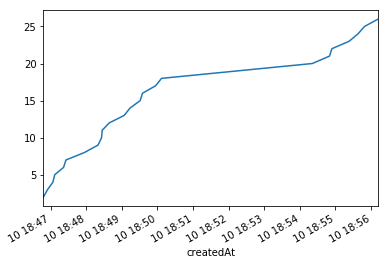

In [4]:
d2 = data.set_index('createdAt').sort_index()
d2['one'] = 1
d2['Players Joined'] = d2['one'].cumsum()
d2['Players Joined'].iloc[1:].plot();


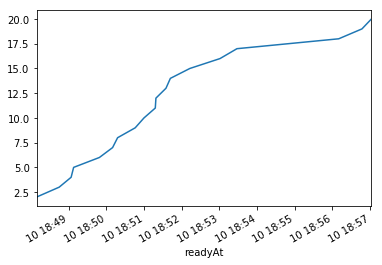

In [5]:
d3 = data[data['exitStatus'] != 'gameFull'].set_index('readyAt').sort_index()
d3['one'] = 1
d3['Players Ready'] = d3['one'].cumsum()
d3['Players Ready'].iloc[1:].plot()

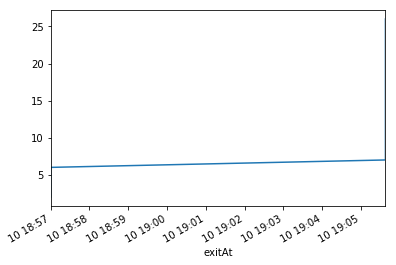

In [6]:
d4 = data.set_index('exitAt').sort_index()
d4['one'] = 1
d4['Players Finished'] = d4['one'].cumsum()
d4['Players Finished'].iloc[1:].plot()


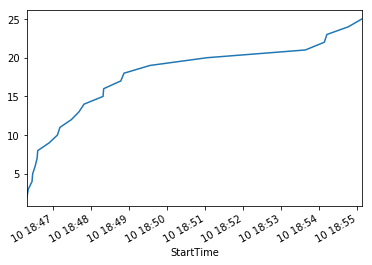

In [7]:
tp_df = pd.read_csv('DG Pilot 2 Jul10 3pm.csv', parse_dates=['StartTime', 'CompletionTime'])
tp_df['StartTime'] = tp_df['StartTime'].apply(lambda t: t.tz_localize('UTC'))
d5 = tp_df.set_index('StartTime').sort_index()
d5['one'] = 1
d5['Players Entered'] = d5['one'].cumsum()
d5['Players Entered'].iloc[1:].plot()

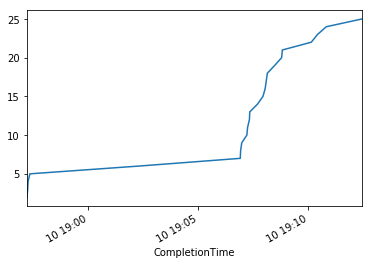

In [8]:
tp_df['CompletionTime'] = tp_df['CompletionTime'].apply(lambda t: t.tz_localize('UTC'))
d6 = tp_df.set_index('CompletionTime').sort_index()
d6['one'] = 1
d6['Players Left'] = d6['one'].cumsum()
d6['Players Left'].iloc[1:].plot()

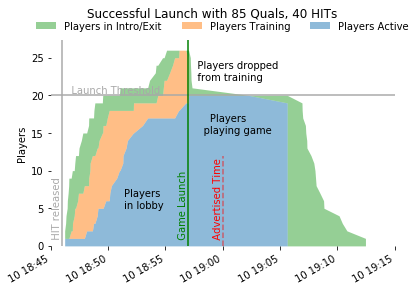

In [18]:
mdf = pd.merge(d3[['Players Ready']], d2[['Players Joined']], left_index=True, right_index=True, how='outer')
mdf = pd.merge(mdf, d4[['Players Finished','exitStatus']], left_index=True, right_index=True, how='outer')
mdf = pd.merge(mdf, d5[['Players Entered']], left_index=True, right_index=True, how='outer')
mdf = pd.merge(mdf, d6[['Players Left']], left_index=True, right_index=True, how='outer')
mdf = mdf.sort_index().fillna(method='ffill').fillna(0)

mdf['Players Online'] = mdf['Players Entered'] - mdf['Players Left'] + 1

mdf['Players On Site'] = mdf['Players Joined'] - mdf['Players Finished']
mdf['Players Active'] = np.minimum(mdf['Players Ready'], mdf['Players On Site'])
mdf['Players Training'] = mdf['Players On Site'] - mdf['Players Active']

mdf['Players in Intro/Exit'] = mdf['Players Online'] - mdf['Players On Site']

mdf[['Players Active', 'Players Training', 'Players in Intro/Exit']].iloc[2:].plot(kind='area', linewidth=0, alpha=.5)
plt.box('off')
plt.xlim(pd.Timestamp('07/10/19 18:45',tz='UTC'), pd.Timestamp('07/10/19 19:15',tz='UTC'))
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='lower center', bbox_to_anchor=(.5,1), ncol=3, frameon=False)
plt.hlines(20, *plt.gca().get_xlim(), color='darkgrey')
start = mdf[mdf['exitStatus']!=0].index[0]
plt.vlines(pd.Timestamp('07/10/19 18:46',tz='UTC'), *plt.gca().get_ylim(), color='darkgrey')
plt.vlines(start, *plt.gca().get_ylim(), color='g')
tickpos, ticklabels = plt.xticks()
plt.vlines(tickpos[3], 0,12, color='r', linestyle='--', alpha=.5)
#plt.gca().set_xticklabels([s.get_text().split(' ')[-1] for s in ticklabels], rotation=0)

plt.text(start, 22, "   Players dropped\n   from training")
plt.text(start, 15, "       Players\n     playing game")
plt.text(start, 5, "Players         \nin lobby        ", ha='right')
plt.text(tickpos[3], 0, "  Advertised Time", rotation=90, color='r', va='bottom', ha='right')
plt.text(start, 0, "  Game Launch", rotation=90, color='g', va='bottom', ha='right')
plt.text(pd.Timestamp('07/10/19 18:46',tz='UTC'), 0, "  HIT released", rotation=90, color='darkgrey', va='bottom', ha='right')
plt.text(pd.Timestamp('07/10/19 18:46',tz='UTC'), 20, "   Launch Threshold", color="darkgrey", ha='left', va='bottom')
plt.suptitle("Successful Launch with 85 Quals, 40 HITs", y=1)
plt.ylabel('Players')
plt.tight_layout()